In [1]:
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns 

import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import RFECV

from scipy.stats import norm 
import statsmodels.api as sm

import warnings  
warnings.filterwarnings('ignore') 

%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_csv('Data/df_engineered_features.csv')
df_numerical = pd.read_csv('Data/df_engineered_numerical.csv')
df_categorical = pd.read_csv('Data/df_engineered_categorical.csv')

## We will now start with the feature selection process.
## My strategy is to:
    1. Build a baseline model with Logistic Regression.
    2. Start with Univariate analysis, selection and compare with baseline. 
    3. Finally, use RFE to compare and remove redundant features.

In [3]:
X = df.drop(['Response'], axis=1)
y = df['Response']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    shuffle = True,
                                                    stratify = y,
                                                    random_state=42)

# Baseline Model - Logistic Regression

In [5]:
# logistic regression object 
lr = LogisticRegression() 
  
# train the model on train set 
lr.fit(X_train, y_train.ravel()) 
  
predictions = lr.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2348
           1       0.69      0.19      0.30       393

    accuracy                           0.87      2741
   macro avg       0.78      0.59      0.61      2741
weighted avg       0.85      0.87      0.84      2741



## Classification Report:
### We will be looking at metrics which measure the performance based on the 'Yes' response as the dataset is imbalanced and a nominal measure like Accuracy won't be able to correctly estimate the results.
### 1. Precision: Proportion of 'Yes response' which are actually 'Yes response'. This is with respect to Predicted Responses
### 2. Recall: Proportion of 'Yes response' which are correctly classified. This is with respect to actual responses. Measures the strength of the model to predict a positive outcome.
### 3. Specificity: Proportion of 'No response' which are correctly classified. This is with respect to actual responses. Measures the strength of the model to predict a negative outcome.

## Our baseline model's Precision and Recall is low. We will try to improve that.

# Feature Selection

## 1.1 Correlation - To reduce Multicollinearity

<AxesSubplot:>

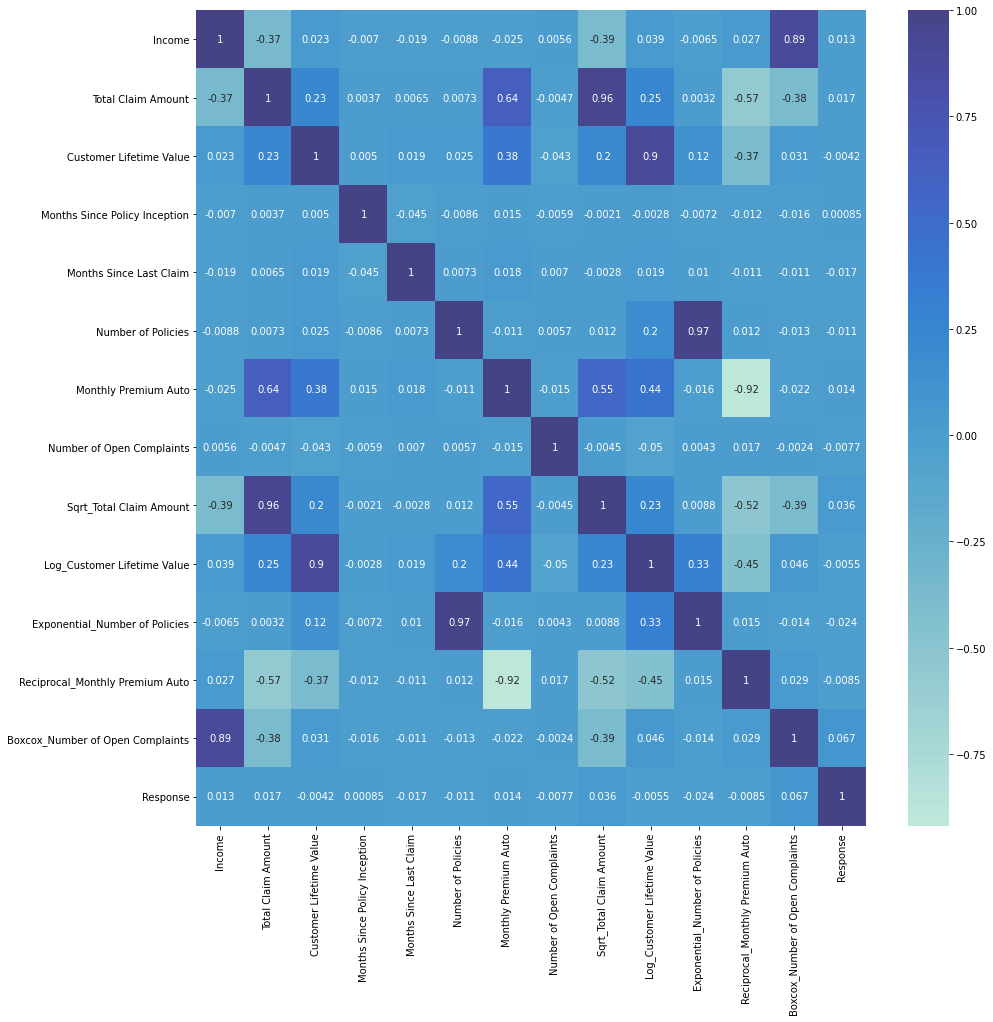

In [6]:
plt.figure(figsize = (15,15))

Num_features = X_train[['Income', 'Total Claim Amount', 'Customer Lifetime Value',
       'Months Since Policy Inception', 'Months Since Last Claim',
       'Number of Policies', 'Monthly Premium Auto',
       'Number of Open Complaints', 'Sqrt_Total Claim Amount',
       'Log_Customer Lifetime Value', 'Exponential_Number of Policies',
       'Reciprocal_Monthly Premium Auto', 'Boxcox_Number of Open Complaints']].join(y_train)

sns.heatmap(Num_features.corr(),
           annot = True,
           center=2)

In [7]:
#Function to find features with correlation above a certain threshold

def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [8]:
correlation(Num_features, 0.85)

{'Boxcox_Number of Open Complaints',
 'Exponential_Number of Policies',
 'Log_Customer Lifetime Value',
 'Reciprocal_Monthly Premium Auto',
 'Sqrt_Total Claim Amount'}

###  Boxcox_Number of Open Complaints feature is highly correlated with the Income feature. We remove the Income feature as it less correlated with the target variable than Boxcox_Number of Open Complaints.  
###  Exponential_Number of Policies feature is highly correlated with its own original feature. We remove the original  feature as it less correlated with the target variable than its respective transformation.
### Log_Customer Lifetime Value feature is highly correlated with its own original feature. We remove the original  feature as it less correlated with the target variable than its respective transformation.
###  Reciprocal_Monthly Premium Auto feature is highly correlated with its own original feature. We remove the transformed feature as it less correlated with the target variable than its original version.
### Sqrt_Total Claim Amount feature is highly correlated with its own original feature. We remove the original  feature as it less correlated with the target variable than its respective transformation.

## Dropping these features

In [9]:
X_train = X_train.drop(['Income','Number of Policies','Customer Lifetime Value','Reciprocal_Monthly Premium Auto','Total Claim Amount'],axis=1)
X_test = X_test.drop(['Income','Number of Policies','Customer Lifetime Value','Reciprocal_Monthly Premium Auto','Total Claim Amount'],axis=1)

## Model - 1.2 - Logistic Regression

In [10]:
# logistic regression object 
lr = LogisticRegression() 
  
# train the model on train set 
lr.fit(X_train, y_train.ravel()) 
  
predictions = lr.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2348
           1       0.71      0.19      0.30       393

    accuracy                           0.87      2741
   macro avg       0.79      0.59      0.62      2741
weighted avg       0.85      0.87      0.84      2741



## There is an improvement in precision but the recall is still same as the base model because it will only imporve if we balance the dataset.

## 2.1 Feature Importance using Ensemble

In [11]:
model = ExtraTreesClassifier()
model.fit(X_train,y_train)

dfscores = pd.DataFrame(model.feature_importances_)
dfcolumns = pd.DataFrame(X_train.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Features','Imp_Score']

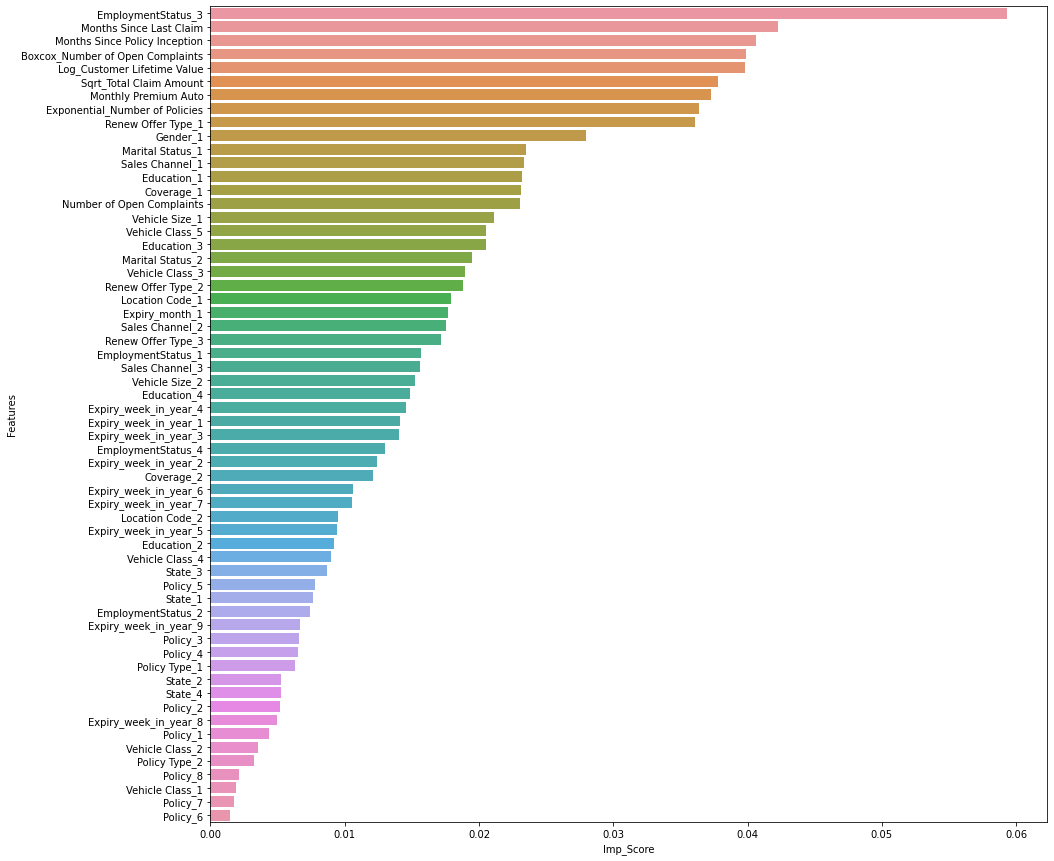

In [12]:
plt.figure(figsize = (15,15))
featureScores = featureScores.sort_values(by = 'Imp_Score',ascending = False )

sns.barplot(x = featureScores['Imp_Score'],
            y=featureScores['Features'])
plt.show()

### Eliminating features which are less than 0.02 Imp_Score threshold

In [13]:
filt = (featureScores['Imp_Score'] > 0.01)
featureScores = featureScores[filt]

In [14]:
featureScores['Features']

28                  EmploymentStatus_3
1              Months Since Last Claim
0        Months Since Policy Inception
7     Boxcox_Number of Open Complaints
5          Log_Customer Lifetime Value
4              Sqrt_Total Claim Amount
2                 Monthly Premium Auto
6       Exponential_Number of Policies
44                  Renew Offer Type_1
49                            Gender_1
30                    Marital Status_1
14                     Sales Channel_1
8                          Education_1
32                          Coverage_1
3            Number of Open Complaints
42                      Vehicle Size_1
25                     Vehicle Class_5
10                         Education_3
31                    Marital Status_2
23                     Vehicle Class_3
45                  Renew Offer Type_2
47                     Location Code_1
50                      Expiry_month_1
15                     Sales Channel_2
46                  Renew Offer Type_3
26                  Emplo

In [15]:
X_train = X_train[['EmploymentStatus_3',
 'Months Since Policy Inception',
 'Months Since Last Claim',
 'Boxcox_Number of Open Complaints',
 'Sqrt_Total Claim Amount',
 'Log_Customer Lifetime Value',
 'Monthly Premium Auto',
 'Exponential_Number of Policies',
 'Renew Offer Type_1',
 'Gender_1',
 'Marital Status_1',
 'Education_1',
 'Coverage_1',
 'Sales Channel_1',
 'Number of Open Complaints',
 'Vehicle Size_1',
 'Education_3']]

X_test = X_test[['EmploymentStatus_3',
 'Months Since Policy Inception',
 'Months Since Last Claim',
 'Boxcox_Number of Open Complaints',
 'Sqrt_Total Claim Amount',
 'Log_Customer Lifetime Value',
 'Monthly Premium Auto',
 'Exponential_Number of Policies',
 'Renew Offer Type_1',
 'Gender_1',
 'Marital Status_1',
 'Education_1',
 'Coverage_1',
 'Sales Channel_1',
 'Number of Open Complaints',
 'Vehicle Size_1',
 'Education_3']]

## Model - 2.2 - Logistic Regression

In [16]:
# logistic regression object 
lr = LogisticRegression() 
  
# train the model on train set 
lr.fit(X_train, y_train.ravel()) 
  
predictions = lr.predict(X_test) 
  
# print classification report 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2348
           1       0.78      0.17      0.27       393

    accuracy                           0.87      2741
   macro avg       0.83      0.58      0.60      2741
weighted avg       0.86      0.87      0.84      2741



## There is a significant improvement in precision from 0.71 from model-1.2 to 0.77

## 3.1 Recursive Feature Elimination with cross validation - Logistic Regression

In [17]:
rfecv = RFECV(estimator=lr, step=1, cv=5, scoring='f1')
rfecv = rfecv.fit(X_train, y_train)
print('Optimal number of features :', rfecv.n_features_)
print('Best features :', X_train.columns[rfecv.support_])

Optimal number of features : 7
Best features : Index(['EmploymentStatus_3', 'Boxcox_Number of Open Complaints',
       'Sqrt_Total Claim Amount', 'Renew Offer Type_1', 'Marital Status_1',
       'Sales Channel_1', 'Education_3'],
      dtype='object')


In [18]:
rfecv_X_train = X_train[['EmploymentStatus_3', 'Boxcox_Number of Open Complaints',
       'Sqrt_Total Claim Amount', 'Renew Offer Type_1', 'Marital Status_1',
       'Sales Channel_1', 'Education_3']]
rfecv_X_test = X_test[['EmploymentStatus_3', 'Boxcox_Number of Open Complaints',
       'Sqrt_Total Claim Amount', 'Renew Offer Type_1', 'Marital Status_1',
       'Sales Channel_1', 'Education_3']]

## Model - 3.2 - Logistic Regression

In [19]:
# logistic regression object 
lr = LogisticRegression() 
  
# train the model on train set 
lr.fit(rfecv_X_train, y_train.ravel()) 
  
predictions = lr.predict(rfecv_X_test) 
  
# print classification report 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2348
           1       0.78      0.17      0.27       393

    accuracy                           0.87      2741
   macro avg       0.83      0.58      0.60      2741
weighted avg       0.86      0.87      0.84      2741



## This is giving us the same score as Model 2.2.

## 4.1 Selecting features based on its p value

In [20]:
total_train = sm.Logit(y_train, X_train)
total_train.fit().summary()

Optimization terminated successfully.
         Current function value: 0.394326
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               Response   No. Observations:                 6393
Model:                          Logit   Df Residuals:                     6376
Method:                           MLE   Df Model:                           16
Date:                Sat, 06 Feb 2021   Pseudo R-squ.:                 0.03963
Time:                        19:58:43   Log-Likelihood:                -2520.9
converged:                       True   LL-Null:                       -2624.9
Covariance Type:            nonrobust   LLR p-value:                 1.877e-35
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
EmploymentStatus_3                   2.8386      0.174     16.335      0.000       2.498       3.179
Months Since Policy Inception        0.0457      0.036      1.268      0.205      -0.025       0.116
Months Since Last Claim              0.0123      0.036      0.342      0.733      -0.058       0.083
Boxcox_Number of Open Complaints     0.3113      0.044      7.020      0.000       0.224       0.398
Sqrt_Total Claim Amount              0.1202      0.051      2.364      0.018       0.021       0.220
Log_Customer Lifetime Value          0.0153      0.043      0.356      0.722      -0.069       0.099
Monthly Premium Auto                 0.0499      0.047      1.058      0.290      -0.042       0.142
Exponential_Number of Policies      -0.0228      0.039     -0.586      0.558      -0.099       0.053
Renew Offer Type_1                   0.7943      0.074     10.768      0.000       0.650       0.939
Gender_1                            -0.4816      0.069     -7.003      0.000      -0.616      -0.347
Marital Status_1                    -1.0162      0.069    -14.745      0.000      -1.151      -0.881
Education_1                         -0.6180      0.083     -7.464      0.000      -0.780      -0.456
Coverage_1                          -0.5887      0.083     -7.088      0.000      -0.751      -0.426
Sales Channel_1                     -0.6398      0.087     -7.395      0.000      -0.809      -0.470
Number of Open Complaints            0.0118      0.036      0.330      0.742      -0.058       0.082
Vehicle Size_1                      -0.8513      0.063    -13.506      0.000      -0.975      -0.728
Education_3                         -0.7850      0.086     -9.161      0.000      -0.953      -0.617
====================================================================================================
"""

## We will be dropping features which have a p value > 0.05. The p value suggests that if given a random model, what is the probability of getting a result as extreme as this. After removing those features, we can say that the remaining independent variables are not recorded just by chance.

#### Final Features Selected:
#### 1. EmploymentStatus_3
#### 2. Boxcox_Number of Open Complaints
#### 3. Sqrt_Total Claim Amount
#### 4. Renew Offer Type_1
#### 5. Gender_1
#### 6. Marital Status_1
#### 7. Education_1
#### 8. Coverage_1
#### 9. Sales Channel_1
#### 10. Vehicle Size_1
#### 11. Education_3

In [21]:
X_train.columns

Index(['EmploymentStatus_3', 'Months Since Policy Inception',
       'Months Since Last Claim', 'Boxcox_Number of Open Complaints',
       'Sqrt_Total Claim Amount', 'Log_Customer Lifetime Value',
       'Monthly Premium Auto', 'Exponential_Number of Policies',
       'Renew Offer Type_1', 'Gender_1', 'Marital Status_1', 'Education_1',
       'Coverage_1', 'Sales Channel_1', 'Number of Open Complaints',
       'Vehicle Size_1', 'Education_3'],
      dtype='object')

In [22]:
final_X_train = X_train[['EmploymentStatus_3',
        'Boxcox_Number of Open Complaints',
       'Sqrt_Total Claim Amount',
       'Renew Offer Type_1', 'Gender_1', 'Marital Status_1', 'Education_1',
       'Coverage_1', 'Sales Channel_1',
       'Vehicle Size_1', 'Education_3']]

final_X_test = X_test[['EmploymentStatus_3',
        'Boxcox_Number of Open Complaints',
       'Sqrt_Total Claim Amount',
       'Renew Offer Type_1', 'Gender_1', 'Marital Status_1', 'Education_1',
       'Coverage_1', 'Sales Channel_1',
       'Vehicle Size_1', 'Education_3']]

## Model - 4.2 - Logistic Regression

In [23]:
# logistic regression object 
lr = LogisticRegression() 
  
# train the model on train set 
lr.fit(final_X_train, y_train.ravel()) 
  
predictions = lr.predict(final_X_test) 
  
# print classification report 
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      2348
           1       0.78      0.17      0.27       393

    accuracy                           0.87      2741
   macro avg       0.83      0.58      0.60      2741
weighted avg       0.86      0.87      0.84      2741



# Creating final Dataframe

In [24]:
df_feature_selected = df[['EmploymentStatus_3',
        'Boxcox_Number of Open Complaints',
       'Sqrt_Total Claim Amount',
       'Renew Offer Type_1', 'Gender_1', 'Marital Status_1', 'Education_1',
       'Coverage_1', 'Sales Channel_1',
       'Vehicle Size_1', 'Education_3', 'Response']]

df_feature_selected.to_csv('Data/df_feature_selected.csv', index = False)